In [195]:
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import RecurrentPPO

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import random

from sympy import Matrix, symbols, eye, KroneckerProduct

import warnings

import csv

import torch

from stable_baselines3.common.callbacks import BaseCallback
import pickle

from stable_baselines3.common.vec_env import SubprocVecEnv

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [87]:
if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Make sure to enable GPU in the runtime settings.")

GPU is not available. Make sure to enable GPU in the runtime settings.


In [88]:
######################################
# Configuration and Hyperparameters
######################################

LEARNING_RATE = 1e-4
ALPHA = 0.7  # Leakage weight
BETA = 0.1   # Closeness weight
GAMMA = 0.2  # Unitarity weight
SEQUENCE_LENGTH = 40  # Number of compositions

In [89]:
class InfoCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(InfoCallback, self).__init__(verbose)
        self.leakage_log = []
        self.closeness_log = []
        self.unitarity_log = []
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_rollout_end(self) -> None:
        pass

    def _on_step(self) -> bool:
        dones = self.locals['dones']  # list[bool], length = number_of_envs
        infos = self.locals['infos']  # list[dict], length = number_of_envs

        for env_idx, done in enumerate(dones):
            if done:
                info = self.locals['infos'][env_idx]
                
                
                # Extract environment-specific metrics from info
                leakage = info.get("leakage", None)
                closeness_error = info.get("closeness_error", None)
                unitarity_error = info.get("unitarity_error", None)
                final_reward = info.get("final_reward", None)
                current_step = info.get("current_step", None)

                # Append them to the logs if available
                if leakage is not None:
                    self.leakage_log.append(leakage)
                if closeness_error is not None:
                    self.closeness_log.append(closeness_error)
                if unitarity_error is not None:
                    self.unitarity_log.append(unitarity_error)
                if final_reward is not None:
                    self.episode_rewards.append(final_reward)
                if current_step is not None:
                    self.episode_lengths.append(current_step)

        # Return True to indicate the training can go on
        return True
    
    def save_callback_data(self, path):
        data = {
            "leakage_log": self.leakage_log,
            "closeness_log": self.closeness_log,
            "unitarity_log": self.unitarity_log,
            "episode_rewards": self.episode_rewards,
            "episode_lengths": self.episode_lengths,
        }
        with open(path, "wb") as f:
            pickle.dump(data, f)

    def load_callback_data(self, path):
        with open(path, "rb") as f:
            data = pickle.load(f)
        self.leakage_log = data["leakage_log"]
        self.closeness_log = data["closeness_log"]
        self.unitarity_log = data["unitarity_log"]
        self.episode_rewards = data["episode_rewards"]
        self.episode_lengths = data["episode_lengths"]


In [90]:
def direct_sum(A, B):
    # Helper function to convert input to a SymPy Matrix
    def to_matrix(x):
        if isinstance(x, Matrix):
            return x
        else:
            # Assume x is a scalar, convert to 1x1 Matrix
            return Matrix([[x]])

    # Convert inputs to matrices
    A_matrix = to_matrix(A)
    B_matrix = to_matrix(B)

    # Check if A_matrix is square
    if A_matrix.rows != A_matrix.cols:
        raise ValueError(f"Matrix A is not square: {A_matrix.rows}x{A_matrix.cols}")

    # Check if B_matrix is square
    if B_matrix.rows != B_matrix.cols:
        raise ValueError(f"Matrix B is not square: {B_matrix.rows}x{B_matrix.cols}")

    # Dimensions
    N = A_matrix.rows
    M = B_matrix.rows

    # Create a zero matrix of size (N+M) x (N+M)
    C = Matrix.zeros(N + M, N + M)

    # Assign A_matrix to the upper-left block
    C[:N, :N] = A_matrix

    # Assign B_matrix to the lower-right block
    C[N:N+M, N:N+M] = B_matrix

    return C

def tensor_product(A, B):
    return KroneckerProduct(A, B)

In [91]:
# R matrix
R_matrix = np.array([
    [ np.exp(-4j * np.pi / 5), 0                      ],
    [ 0                      , np.exp(3j * np.pi / 5) ]
])

R_tt1 = symbols("R_tt1")  # Top-left diagonal
R_ttt = symbols("R_ttt")  # Bottom-right diagonal

sym_R = Matrix([
    [R_tt1, 0],
    [0, R_ttt]
])

# F matrix
phi = (1 + np.sqrt(5)) / 2  # Golden ratio
F_matrix = np.array([
    [ 1/phi          , np.sqrt(1/phi) ],
    [ np.sqrt(1/phi) , -1/phi         ]
])

F_11 =  symbols("F_11")
F_12 =  symbols("F_12")
F_21 =  symbols("F_21")
F_22 =  symbols("F_22")

sym_F = Matrix([
    [F_11, F_12],
    [F_21, F_22]
])

# Substitution dictionary
subs = {
    R_tt1: R_matrix[0, 0],
    R_ttt: R_matrix[1, 1],
    F_11: F_matrix[0, 0],
    F_12: F_matrix[1, 0],
    F_21: F_matrix[0, 1],
    F_22: F_matrix[1, 1]
}

# Permutation matrix
I_2 = eye(2)

I_5 = eye(5)
I_5.row_swap(0, 3)
P14 = I_5


In [92]:
# Braid representations

rho_1 = direct_sum(R_ttt, tensor_product(sym_R, I_2).doit())

rho_2 = direct_sum(R_ttt, tensor_product(sym_F * sym_R * sym_F, I_2).doit())

rho_3 = P14 * direct_sum(R_ttt, direct_sum(sym_R, sym_F * sym_R * sym_F)) * P14

rho_4 = direct_sum(R_ttt, tensor_product(I_2, sym_F * sym_R * sym_F).doit())

rho_5 = direct_sum(R_ttt, tensor_product(I_2, sym_R).doit())

# CNOT gate
cnot_gate = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

dcnot_gate = Matrix([
    1, 0, 0, 0,
    0, 0, 1, 0,
    0, 0, 0, 1,
    0, 1, 0, 0
])

swap_gate = Matrix([
    1, 0, 0, 0,
    0, 0, 1, 0,
    0, 1, 0, 0,
    0, 0, 0, 1    
])

In [93]:
class GateApproxEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, braid_gates, target_gate, subs, max_length,
                 alpha, beta, gamma, local_equivalence_class):
        super(GateApproxEnv, self).__init__()

        self.max_length = max_length
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.local_equivalence_class = local_equivalence_class

        # Precompute numeric versions of braid_gates
        self.braid_gates = []
        for g in braid_gates:
            g_evaluated = g.subs(subs).evalf()
            if any(sym.is_symbol for sym in g_evaluated):
                raise ValueError("Not all symbols substituted in a braid gate.")
            self.braid_gates.append(np.array(g_evaluated.tolist(), dtype=complex))

        # Precompute numeric target gate
        t_evaluated = target_gate.subs(subs).evalf()
        if any(sym.is_symbol for sym in t_evaluated):
            raise ValueError("Not all symbols substituted in target_gate.")
        self.target_gate = np.array(t_evaluated.tolist(), dtype=complex)

        # Action space: One action per braid gate
        self.action_space = spaces.Discrete(len(self.braid_gates))

        # Observation: Flattened real+imag parts of the 5x5 gate = 50-dim vector
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(50,), dtype=np.float64)

        self.reset_composition()

    def reset_composition(self):
        self.current_composition = np.eye(5, dtype=complex)
        self.current_length = 0
        self.gate_stack = []

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.reset_composition()
        self.current_step = 0

        # Randomize the episode length 
        self.random_episode_length = random.randint(20, self.max_length)

        # Compute initial errors (for reward shaping)
        leak_err, uni_err, close_err, _ = self.compute_reward()
        self.prev_leakage = leak_err
        self.prev_unitarity_error = uni_err
        self.prev_closeness_error = close_err

        # Store a "prev total error" to measure improvement
        self.prev_total_error = (self.alpha * leak_err 
                                 + self.beta * close_err 
                                 + self.gamma * uni_err)

        return self._get_obs(), {}
    
    def take_action(self, action):
        if self.current_length < self.max_length:
            # Numeric matrix multiplication only
            self.current_composition = self.current_composition @ self.braid_gates[action]
            self.gate_stack.append(f"{action}")
            self.current_length += 1
        else:
            print("Warning: Maximum composition length reached. No action taken.")

    def compute_reward(self):
        # Current composition is already numeric
        M = self.current_composition
        T = self.target_gate

        # Leakage: abs(M[0,0])
        leakage = np.abs(M[0,0])
        # Avoid dividing by zero if leakage is extremely small:
        if leakage < 1e-12:
            leakage = 1e-12
        #leakage_error = 1.0 / leakage

        leakage_error = (1.0 - leakage)

        # Extract 4x4 submatrix
        M_4x4 = M[1:5, 1:5]

        # Unitarity check
        UdagU = M_4x4.conjugate().T @ M_4x4
        unitarity_error = self.schatten_p_norm(UdagU - np.eye(4), 1)

        # Closeness to target
        if self.local_equivalence_class:
            closeness_error = self.local_equivalence_distance(T, M_4x4)
        else:
            # Schatten 2-norm difference between normalized gates
            A_norm = self.schatten_p_norm(M_4x4, 2)
            T_norm = self.schatten_p_norm(T, 2)

            if A_norm < 1e-12:  # safeguard
                A_norm = 1e-12
            if T_norm < 1e-12:
                T_norm = 1e-12

            A_normalized = M_4x4 / A_norm
            T_normalized = T / T_norm
            closeness_error = self.schatten_p_norm(A_normalized - T_normalized, 2)

        # Reward (negative weighted sum)
        reward = - (self.alpha * leakage_error + self.beta * closeness_error + self.gamma * unitarity_error)
        
        return float(leakage), float(closeness_error), float(unitarity_error), float(reward)
    
    def step(self, action):

        old_total_error = self.prev_total_error

        # 2. Take action
        self.take_action(action)
        self.current_step += 1

        # 3. Compute new error
        leakage, closeness_error, unitarity_error, combined_reward = self.compute_reward()
        new_total_error = (self.alpha * (1.0 - leakage) + self.beta * closeness_error + self.gamma * unitarity_error)

        # 4. Provide incremental reward for improvement
        # If we reduced total_error, that's an improvement => positive reward
        improvement = old_total_error - new_total_error
        step_reward = improvement 

        # Update stored "previous" values for next step
        self.prev_leakage = leakage
        self.prev_unitarity_error = unitarity_error
        self.prev_closeness_error = closeness_error
        self.prev_total_error = new_total_error

        terminated = (self.current_step >= self.random_episode_length)
        truncated = False

        info = {}

        # If the episode terminates, add a final reward that reflects
        # the final composition's closeness to target
        if terminated:
            step_reward += combined_reward

            # Compute final 4x4 submatrix and Makhlin invariants:
            M_4x4 = self.current_composition[1:5, 1:5]
            g_1, g_2, g_3 = self.compute_makhlin_invariants(M_4x4)

            info = {
                "current_step": self.current_step,
                "gate_stack": self.gate_stack.copy(),
                "leakage": leakage,
                "closeness_error": closeness_error,
                "unitarity_error": unitarity_error,
                "combined_reward": combined_reward,
                "improvement": improvement,
                "final_reward": step_reward if terminated else None,
                "g_1":g_1,
                "g_2":g_2,
                "g_3":g_3,
                "M_4x4": M_4x4
            }

        obs = self._get_obs()

        return obs, step_reward, terminated, truncated, info

    def _get_obs(self):
        # current_composition is numeric, just flatten
        M = self.current_composition
        obs = np.concatenate([M.real.flatten(), M.imag.flatten()])
        return obs

    """
    def schatten_p_norm(self, T, p):

        # Compute |T| = sqrt(T^† T)
        abs_T = sqrtm(T.conj().T @ T)

        # Compute |T|^p
        abs_T_p = np.linalg.matrix_power(abs_T, p)

        # Compute the trace of |T|^p
        trace_value = np.trace(abs_T_p)

        # Compute the Schatten p-norm
        schatten_norm = np.real(trace_value)**(1/p)

        return schatten_norm
    """

    def schatten_p_norm(self, T, p):
        # Ensure T is a NumPy array
        T = np.array(T, dtype=complex)

        # Compute singular values of T
        singular_values = np.linalg.svd(T, compute_uv=False)

        # Compute Schatten p-norm
        if p == np.inf:  # Special case for p = infinity
            schatten_norm = np.max(singular_values)
        elif p == 1:  # Special case for p = 1 (nuclear norm)
            schatten_norm = np.sum(singular_values)
        else:
            # General case for arbitrary p
            schatten_norm = (np.sum(singular_values**p))**(1/p)

        return schatten_norm

    def compute_makhlin_invariants(self, U):

        i = 1j  # Complex unit (sqrt(-1))
        Q = (1 / np.sqrt(2)) * np.array([
            [1,  0,  0,  i],
            [0,  i,  1,  0],
            [0,  i, -1,  0],
            [1,  0,  0, -i]
        ], dtype=complex)

        # Compute U_B = Q^\dagger U Q
        U_B = Q.conjugate().T @ U @ Q

        # Makhlin matrix: m_U = (U_B)^T U_B
        m_U = (U_B.T) @ U_B

        # Compute trace and related quantities
        tr_mU = np.trace(m_U)
        tr_mU2 = np.trace(m_U @ m_U)
        det_U = np.linalg.det(U)  # determinant of U

        if np.abs(det_U) < 1e-12:
            print("Warning: Determinant is very small, adding regularization.")
            det_U += 1e-12


        # Compute complex quantity: (tr^2(m_U) / (16 * det(U)))
        complex_val = (tr_mU**2) / (16.0 * det_U)

        # g_1 = Re{complex_val}
        g_1 = complex_val.real

        # g_2 = Im{complex_val}
        g_2 = complex_val.imag

        # g_3 = (tr^2(m_U) - tr(m_U^2)) / (4 * det(U))
        g_3 = ((tr_mU**2) - tr_mU2) / (4.0 * det_U)

        return (g_1, g_2, g_3)

    def local_equivalence_distance(self, E, U):
        # Compute Makhlin invariants for E and U
        gE = self.compute_makhlin_invariants(E)
        gU = self.compute_makhlin_invariants(U)

        # Compute Δg_i and sum their squares
        diff_squares = [(abs(e - u))**2 for e, u in zip(gE, gU)]
        d_EU = sum(diff_squares)
        return d_EU
    


    def get_gate_composition(self, gate_string: str) -> np.ndarray:
        composition = np.eye(5, dtype=complex)
        for char in gate_string:
            try:
                gate_index = int(char)
            except ValueError:
                raise ValueError(f"Invalid character '{char}' in gate string. Must be a digit.")

            if gate_index < 0 or gate_index >= len(self.braid_gates):
                raise IndexError(f"Gate index {gate_index} is out of bounds for the available braid gates.")

            composition = composition @ self.braid_gates[gate_index]
        return composition



In [94]:
#braid_gates = [rho_1, rho_2, rho_3, rho_4, rho_5]


braid_gates = [
        rho_1,       rho_2,       rho_3,       rho_4,       rho_5,
        rho_1.inv(), rho_2.inv(), rho_3.inv(), rho_4.inv(), rho_5.inv()
    ]


target_gate = cnot_gate

In [162]:
def make_gate_approx_env(env_kwargs):
    def _init():
        env = GateApproxEnv(**env_kwargs)
  
        # env.seed(seed + rank)  
        return env
    return _init

env_kwargs = {
    "braid_gates": braid_gates,        
    "target_gate": target_gate,        
    "subs": subs,                      
    "max_length": SEQUENCE_LENGTH,                  
    "alpha": ALPHA,
    "beta": BETA,
    "gamma": GAMMA,
    "local_equivalence_class": True
}

num_envs = 8  # number of parallel processes

# Build a list of environment-initializer callables
env_fns = [make_gate_approx_env(env_kwargs)
           for i in range(num_envs)]

# Create the SubprocVecEnv
vec_env = SubprocVecEnv(env_fns)

In [121]:
total_timesteps = 30000
verbose = 1

policy_kwargs = dict(net_arch=[512, 256, 128, 64])
model = RecurrentPPO(
    "MlpLstmPolicy",
    vec_env,
    #env,
    policy_kwargs=policy_kwargs,
    #device="cuda",
    verbose=verbose,
    learning_rate=LEARNING_RATE,
    gamma=0.9,
    tensorboard_log="./tensorboard_logs/"
    )

info_callback = InfoCallback()
model.learn(total_timesteps=total_timesteps, callback=info_callback)


Using cpu device
Logging to ./tensorboard_logs/RecurrentPPO_12
-----------------------------
| time/              |      |
|    fps             | 2433 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 209         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.004382415 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | 0.0194      |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0191      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 0.0498      |
-------------

In [122]:
def plot_training_metrics(callback: InfoCallback):
    # We have as many episodes as the length of the final_reward log,
    # or closeness_log, or leakage_log -- ideally they should match
    episodes = range(1, len(callback.episode_rewards) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    

    # Episode Final Reward
    axs[0, 0].plot(episodes, callback.episode_rewards, label='Final Episode Reward')
    #axs[0, 0].set_yscale('log')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Reward')
    axs[0, 0].set_title('Episode Final Rewards')
    axs[0, 0].legend()

    # Leakage
    axs[0, 1].plot(episodes, callback.leakage_log, color='orange', label='Leakage')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Leakage')
    axs[0, 1].set_title('Leakage per Episode')
    axs[0, 1].legend()

    # Closeness Error
    axs[1, 0].plot(episodes, callback.closeness_log, color='green', label='Closeness Error')
    #axs[1, 0].set_yscale('log')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Closeness Error')
    axs[1, 0].set_title('Closeness per Episode')
    axs[1, 0].legend()

    # Unitarity Error
    axs[1, 1].plot(episodes, callback.unitarity_log, color='red', label='Unitarity Error')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Unitarity Error')
    axs[1, 1].set_title('Unitarity per Episode')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


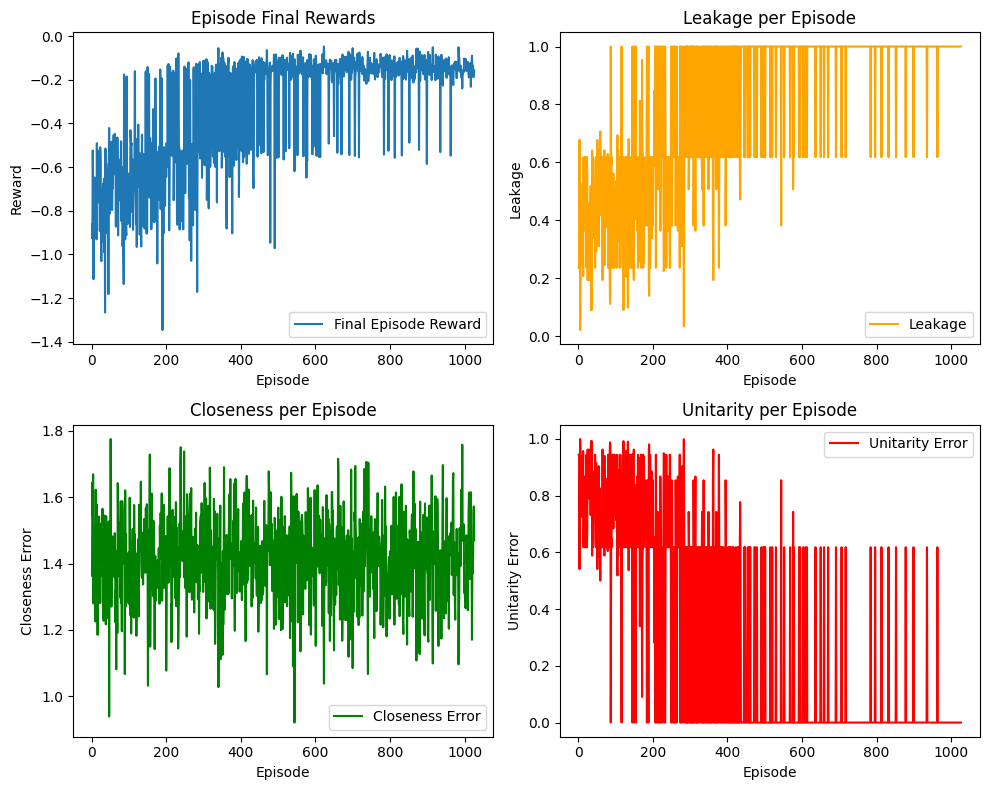

In [123]:
# Plot the main metrics
plot_training_metrics(info_callback)

In [124]:
def plot_low_unitary_acceleration(callback, threshold=0.001, increment=1.0):
    # Convert the unitarity log into a NumPy array.
    errors = np.array(callback.unitarity_log)
    num_episodes = len(errors)
    
    # Initialize the cumulative array.
    cumulative = np.zeros(num_episodes)
    
    # For each episode, if the unitarity error is below threshold,
    # subtract 'decrement' from the cumulative value.
    for i in range(num_episodes):
        if i > 0:
            cumulative[i] = cumulative[i-1]
        if errors[i] < threshold:
            cumulative[i] += increment

    episodes = np.arange(1, num_episodes + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, cumulative, marker='.', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Low-Error Score")
    plt.title("Acceleration of Achieving Low Unitarity Error")
    plt.grid(True)
    plt.show()

def plot_low_leakage_acceleration(callback, threshold=0.9, increment=1.0):
    # Get leakage errors as a NumPy array.
    leakage_errors = np.array(callback.leakage_log)
    num_episodes = len(leakage_errors)
    
    # Initialize the cumulative score array.
    cumulative = np.zeros(num_episodes)
    
    # For each episode, if leakage is below the threshold, decrement the cumulative score.
    for i in range(num_episodes):
        if i > 0:
            cumulative[i] = cumulative[i-1]
        if leakage_errors[i] > threshold:
            cumulative[i] += increment

    episodes = np.arange(1, num_episodes + 1)
    
    # Plot the cumulative score.
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, cumulative, marker='.', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Low-Leakage Score")
    plt.title("Acceleration of Achieving Low Leakage")
    plt.grid(True)
    plt.show()

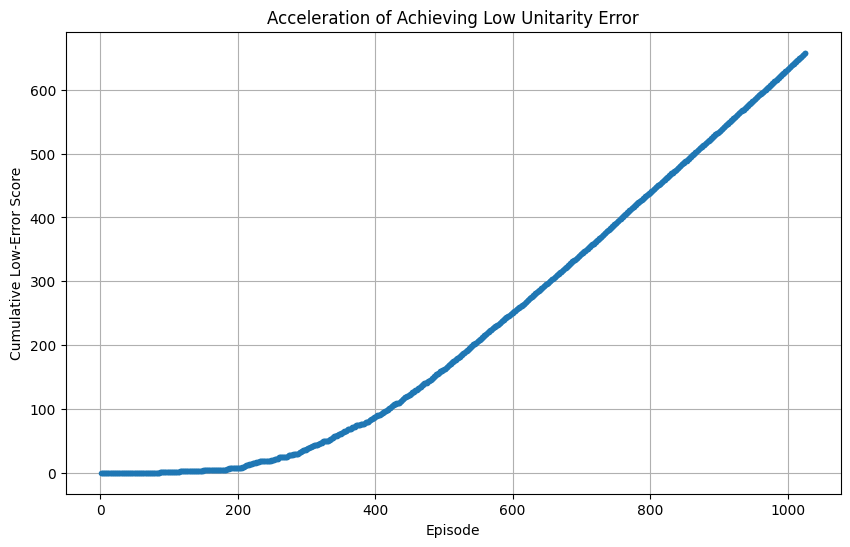

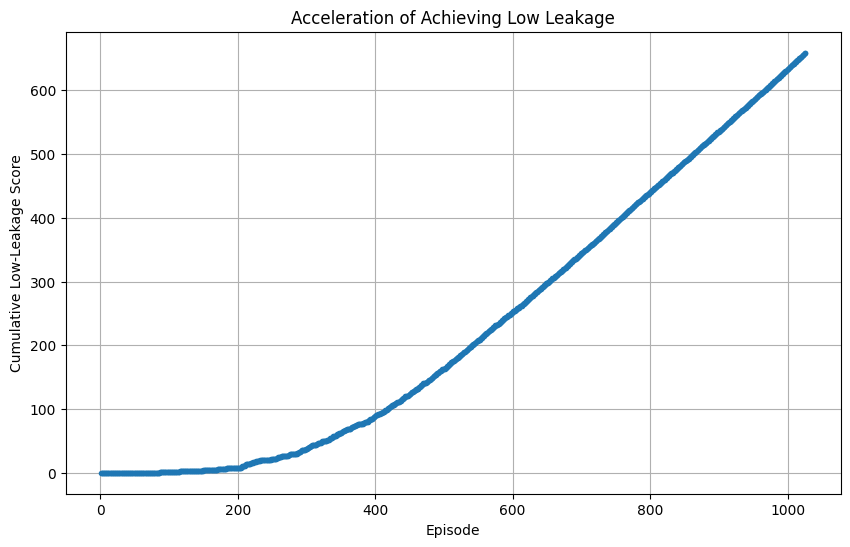

In [125]:
# Example usage:
plot_low_unitary_acceleration(info_callback, threshold=0.0000000000001, increment=1.0)

# Example usage:
plot_low_leakage_acceleration(info_callback, threshold=0.95, increment=1.0)

In [172]:
def evaluate_policy_vec(env, model, num_sequences, csv_filename="results_lec.csv"):
    SEQUENCE_LENGTH = getattr(env, 'max_length', 10)
    max_operator_width = SEQUENCE_LENGTH
    operator_column_width = max(max_operator_width, 10)

    # Open CSV file for writing
    with open(csv_filename, "w", newline="") as csvfile:
        fieldnames = ["Closeness", "Leakage", "Unitarity", "Operator"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Reset all parallel environments at once
        obs = env.reset()  # Assuming single return value
        episodes_collected = 0

        while episodes_collected < num_sequences:
            actions, _ = model.predict(obs, deterministic=False)
            obs, _, dones, infos = env.step(actions)

            for i in range(env.num_envs):
                if dones[i]:
                    episodes_collected += 1
                    gate_stack = infos[i].get("gate_stack", [])
                    operator_string = ''.join(map(str, gate_stack))

                    closeness_error = infos[i].get("closeness_error", 9999)
                    leakage = infos[i].get("leakage", 0.0)
                    unitarity_error = infos[i].get("unitarity_error", 9999)

                    # Retrieve Makhlin invariants if needed:
                    # g_1 = infos[i].get("g_1", float('nan'))
                    # g_2 = infos[i].get("g_2", float('nan'))
                    # g_3 = infos[i].get("g_3", float('nan'))

                    # Output row only if the condition is met:
                    if closeness_error < .0001 and (leakage > 0.98):
                    #if (closeness_error < 0.9) and (leakage > 0.8) and (unitarity_error < 1e-10):
                        writer.writerow({
                            "Closeness": f"{closeness_error:.4e}",
                            "Leakage": f"{leakage:.3f}",
                            "Unitarity": f"{unitarity_error:.3e}",
                            "Operator": operator_string
                        })

                    if episodes_collected >= num_sequences:
                        break

            if episodes_collected >= num_sequences:
                break

    print(f"Results exported to {csv_filename}")


In [173]:
loaded_model = PPO.load("working_model", env=vec_env) # 21 to 40

#loaded_model = PPO.load("length_3_inv_model", env=vec_env)
#loaded_model = PPO.load("length_4_inv_model", env=vec_env)
#loaded_model = PPO.load("length_5_inv_model", env=vec_env)
#loaded_model = PPO.load("length_6_inv_model", env=vec_env)
#loaded_model = PPO.load("length_7_inv_model", env=vec_env)

#loaded_model = PPO.load("length_10_inv_model", env=vec_env)
#loaded_model = PPO.load("length_20_inv_model", env=vec_env)
#loaded_model = PPO.load("length_21_inv_model", env=vec_env)

In [174]:
evaluate_policy_vec(vec_env, loaded_model, num_sequences=500000)

Results exported to results_lec.csv


In [153]:
#model.save("length_20_inv_model")

# The following is test code and is inherently unstructured and messy

In [196]:
gates = [
    "7397799322", # 10
    "373373739737937373373", #21
    "373373733743000773323", #21
    "373323393737332975373" #21
    "373373787477337373373", #21
    "373373733743035223733", #21
    "373373747337334323737", #21
    "70747074804807470770", #20
    "74715417175771747519" #20
]

In [22]:
def string_to_gate_composition(gate_string: str, braid_gates: list) -> np.ndarray:
    # Initialize composition as the 5x5 identity matrix.
    composition = np.eye(5, dtype=complex)

    # Iterate over each character in the string.
    for char in gate_string:
        # Convert the character to an integer index.
        try:
            gate_index = int(char)
        except ValueError:
            raise ValueError(f"Invalid character '{char}' in gate string. Must be a digit.")

        # Check that the index is within the valid range.
        if gate_index < 0 or gate_index >= len(braid_gates):
            raise IndexError(f"Gate index {gate_index} is out of bounds for the available braid gates.")

        # Multiply the current composition by the braid gate.
        composition = composition @ braid_gates[gate_index]
    
    return composition


In [194]:
def print_gate_metrics(gate_strings, env, csv_filename="gate_metrics.csv"):
    # Determine the maximum width for the "Operator" column for nice formatting.
    max_operator_width = max(len(str(g)) for g in gate_strings)
    operator_column_width = max(max_operator_width, 10)  # Ensure at least 10 characters for aesthetics

    # Print table header to the console
    header = (f"{'Operator':<{operator_column_width}} | "
              f"{'Closeness':<10} | {'Leakage':<10} | {'Unitarity':<10}")
    print(header)
    print("-" * (operator_column_width + 34))

    # Open CSV file for writing the results.
    with open(csv_filename, "w", newline="") as csvfile:
        fieldnames = ["Operator", "Closeness", "Leakage", "Unitarity"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Process each gate string.
        for gate_str in gate_strings:
            # Reset the current composition in the environment.
            env.reset_composition()
            
            # Compute the gate composition for the given string.
            gate_matrix = env.get_gate_composition(gate_str)
            
            # Update the environment's composition to the computed gate.
            env.current_composition = gate_matrix
            
            # Compute the metrics for the current composition.
            leakage, closeness_error, unitarity_error, total_error = env.compute_reward()
            
            # Optionally, set unitarity error to exactly zero if very small.
            if unitarity_error < 0.0001:
                unitarity_error = 0.0
            
            # Format and print the row with the gate metrics.
            print(f"{gate_str:<{operator_column_width}} | "
                  f"{closeness_error:<10.3e} | "
                  f"{leakage:<10.3f} | "
                  f"{unitarity_error:<10.3e}")
            
            # Write the row to the CSV file
            writer.writerow({
                "Operator": gate_str,
                "Closeness": f"{closeness_error:.3e}",
                "Leakage": f"{leakage:.3f}",
                "Unitarity": f"{unitarity_error:.3e}"
            })

    print(f"Gate metrics have been written to {csv_filename}")


In [190]:
"""
test = ["30",
        "880",
        "5300",
        "48440",
        "553000",
        "4334300",
        "37770000",
        "441001048",
        "2555337582",
        "59672955693",
        "374050007970",
        "306947382105",
        "6595888969003",
        "75139699757375",
        "78450807782427077787",
        "287430798424700981936977"
        ]
"""
"""
test = [
    "000",
    "0000",
    "00000",
    "222000",
    "0000000",
    "00000000",
    "000000000",
    "2221001222",
    "22210012220",
    "223443100122",
    "2213404301242",
    "34224334310031224",
    "242314040312211412221",
    "422211222020214000112021",
    "101422102223130431111322222",
    "31423322434332420442310301422",
    "222223043422422024043333320003",
    "2344130440331032213334400344312",
    "423330314001220244224333334034032",
    "132424244140142042111112011202122020400",
    "231333001244422220433403402422343302043"
]
"""

'\ntest = [\n    "000",\n    "0000",\n    "00000",\n    "222000",\n    "0000000",\n    "00000000",\n    "000000000",\n    "2221001222",\n    "22210012220",\n    "223443100122",\n    "2213404301242",\n    "34224334310031224",\n    "242314040312211412221",\n    "422211222020214000112021",\n    "101422102223130431111322222",\n    "31423322434332420442310301422",\n    "222223043422422024043333320003",\n    "2344130440331032213334400344312",\n    "423330314001220244224333334034032",\n    "132424244140142042111112011202122020400",\n    "231333001244422220433403402422343302043"\n]\n'

In [191]:
found_gates = [
    "373373739737937373373", #21
    "373373733743000773323", #21
    "373323393737332975373" #21
    "373373787477337373373", #21
    "373373733743035223733", #21
    "373373747337334323737", #21
    "70747074804807470770", #20
    "74715417175771747519", #20
    "124543537528586425295552041721248", 
    "3304508631218099892215222273419788357195",
    "2522122520252241121222952",
    "2122521290220262257522525",
    "212212922221206520262657",
    "252282524225252528922929527272252",
    "29220239322922922922920222292927209229",
    "7545960196017659606465541914747",
    "226262460644262626167206626272090226",
    "246060662626072722621262727272727206626",
    "272776262720226242026442267",
    "27272722626202724625625226244616",
    "27226262721242606620229262026226262622",
    "7397799322",
    "373373739737937373373",
    "373373733743000773323",
    "2262620207742620262",
    "206724676460242606626764692627272720202",
    "226262020662676402622629720127202662",
    "2262627262020662620962262",
    "22626246064426262606626242026",
    "2262624672064427262672722672066262427242",
    "272262627246727292020662620962267922"
    ]

In [192]:
def reduce_sequence(seq: str) -> str:
    
    # Inverse mapping: each key is the inverse of its value.
    inv_map = {
        '0': '5', '1': '6', '2': '7', '3': '8', '4': '9',
        '5': '0', '6': '1', '7': '2', '8': '3', '9': '4'
    }
    
    stack = []
    for char in seq:
        # Check if the last element in stack is the inverse of current char.
        if stack and inv_map[char] == stack[-1]:
            stack.pop()
        else:
            stack.append(char)
    
    return ''.join(stack)

In [193]:
reduced_found_gates = []

 # Process and print the reduced sequences
for i, seq in enumerate(found_gates, 1):
    reduced = reduce_sequence(seq)
    print(f"Sequence {i}: Original: {seq}")
    print(f"            Reduced:  {reduced}\n")
    reduced_found_gates.append(reduced)

Sequence 1: Original: 373373739737937373373
            Reduced:  373373739737937373373

Sequence 2: Original: 373373733743000773323
            Reduced:  373373733743000773323

Sequence 3: Original: 373323393737332975373373373787477337373373
            Reduced:  373323393737332975373373373787477337373373

Sequence 4: Original: 373373733743035223733
            Reduced:  373373733743035223733

Sequence 5: Original: 373373747337334323737
            Reduced:  373373747337334323737

Sequence 6: Original: 70747074804807470770
            Reduced:  70747074804807470770

Sequence 7: Original: 74715417175771747519
            Reduced:  74715417175771747519

Sequence 8: Original: 124543537528586425295552041721248
            Reduced:  1245435375285864252955520411248

Sequence 9: Original: 3304508631218099892215222273419788357195
            Reduced:  3304863121809989221522234197857195

Sequence 10: Original: 2522122520252241121222952
            Reduced:  2522122520252241121222952

Sequence 

In [188]:
env = GateApproxEnv(
    braid_gates=braid_gates,
    target_gate=target_gate,
    subs=subs,
    max_length=SEQUENCE_LENGTH,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA,
    local_equivalence_class=True
)
print_gate_metrics(reduced_found_gates, env)


Operator                                   | Closeness  | Leakage    | Unitarity 
----------------------------------------------------------------------------
373373739737937373373                      | 1.202e-09  | 0.992      | 1.594e-02 
373373733743000773323                      | 1.953e-02  | 0.980      | 4.031e-02 
373323393737332975373373373787477337373373 | 8.928e-01  | 0.936      | 1.238e-01 
373373733743035223733                      | 1.953e-02  | 0.980      | 4.031e-02 
373373747337334323737                      | 7.051e-02  | 0.982      | 3.506e-02 
70747074804807470770                       | 6.785e-02  | 0.984      | 3.207e-02 
74715417175771747519                       | 1.264e-02  | 0.990      | 1.962e-02 
1245435375285864252955520411248            | 3.380e-06  | 0.944      | 1.084e-01 
3304863121809989221522234197857195         | 2.169e-05  | 0.976      | 4.760e-02 
2522122520252241121222952                  | 1.042e-07  | 0.943      | 1.110e-01 
212252129022026225752